# Sinusoidal effects on Direct location 

This tutorial shows 2 ways to generate `sinusoidal perturbation` on the line of sight (LOS) of a satellite's line sensor. This notebook is based on 'tutorial 1' of the `Pyrugged` examples: 'direct_location.ipynb'. We advise you to have a look at this notebook before reading the following.  
The sinusoidal pertubation deviates the LOS by an angle define as follow:  
$$angle = \alpha \sin(2\pi f t + \phi)$$
With $\alpha$ the amplitude in radians, f the frequency in Hz, t the time ins second, and phi the phase.  

The first part explains how to implement sinusoidal perturbation when you build a line sensor using `Pyrugged` LOSBuilder object.  
The second part explains how to set sinusoidal perturbation when you import dimap data using `PydimapRugged` and how it affects geolocation of satellite image

### Module imports

In [13]:
import orekit

import numpy as np
import matplotlib.pyplot as plt

from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.time import AbsoluteDate
from org.orekit.time import TimeScalesFactory

from pyrugged.configuration.init_orekit import init_orekit
from pyrugged.los.sinusoidal_rotation import SinusoidalRotation
from pyrugged.los.los_builder import LOSBuilder
from pyrugged.line_sensor.line_sensor import LineSensor
from pyrugged.line_sensor.linear_line_datation import LinearLineDatation

from pydimaprugged.utils.proj_utils import change_crs
from pydimaprugged.process.pyrugged_initialization import initialize_pyrugged

### Initialization 

initialize Orekit

In [14]:
init_orekit()

---

## 1 - Generate sinusoidal perturbation using Pyrugged LOSBuilder object

In this part, we will use Pyrugged `LOSBuilder` object and the `add_transform` method to generate perturbed line of sight (LOS) following a sinusoidal function from raw LOS.

### Generate raw LOS

In [15]:
raw_dirs = []
for i in range(2000):
    raw_dirs.append(
        Vector3D(0.0, (-1000+i) * float(np.radians(1)) / 2000.0, 1.0)
    )

### Define line datation model

Since the sinusoidal function is time dependent, we have to define the time model before the LOSBuilder.

In [16]:
gps = TimeScalesFactory.getGPS() #time frame (gps)
abs_date = AbsoluteDate("2009-12-11T16:59:30.0", gps)
line_datation = LinearLineDatation(
    abs_date, 1.0, 20
)

### Build LOS from raw los

We use the `SinusoidalRotation` object, very similar to the `PolynomialRotation` object used in the tutorial 1. The constructor of this object takes for arguments the following:  
-The name of the transform  :  str  
-The axis around which the (sinusoidal) rotation take place  :  Vector3D
-The reference date to set a time frame for the sinusoide function  :  AbsoluteDate  
-The amplitude of the sinusoide in radians  :  float
-The frequency of the sinusoide in Hz  :  float  
-The phase of the sinusoide  :  float

In [17]:
los_builder = LOSBuilder(raw_dirs)
los_builder.add_los_transform(
    SinusoidalRotation(
        "sinusoidal rotation",
        Vector3D.PLUS_J, #rotation axis
        reference_date = abs_date,
        amplitude = 1e-4,
        frequency = 30,
        phase = 0
    )
)
line_of_sight = los_builder.build()


### Generate the line sensor

In [18]:
line_sensor = LineSensor(
    "my-sensor2",
    line_datation,
    Vector3D.ZERO,
    line_of_sight,
)

You can now use the line_sensor as you usually do, and use it to build a Pyrugged instance. The line_senor LOS have been affected by the sinusoidal perturbation.

---

## 2 - Generate sinusoidal perturbation using Pydimaprugged API and dimap data

In this part, we will use Pydimaprugged to import dimap data and affect them by a sinusoidal perturbation. We use a real dimap file ('DIM_PHR1A_P_201202250025599_SEN_PRG_FC_5847-001.XML') of a satellite's line sensor pointing at nadir for an easier way to analyze the perturbation's effect.

### Pyrugged initilization

We use Pydimaprugged to initialize pyrugged using the dimap file, and the argument of the sinusoidal perturbation.

In [19]:
location_no_pert,parser = initialize_pyrugged( #none perturbated location for reference
    "DIM_PHR1A_P_201202250025599_SEN_PRG_FC_5847-001.XML",
    "pleiade_sensor",
    amplitude = 0, #alpha, amplitude of the sinusoide in radians
    frequency = 30, #f, frequency of the sinusoide in Hz
    phase = 0, #phi, the phase of the sinusoide
    axis = Vector3D.PLUS_J, #axis of the (sinusoidale) rotation
    )

location_pert,parser = initialize_pyrugged(#perturbated location
    "DIM_PHR1A_P_201202250025599_SEN_PRG_FC_5847-001.XML",
    "pleiade_sensor",
    amplitude = 1e-4, 
    frequency = 30, 
    phase = 0,
    axis = Vector3D.PLUS_J,
    )

  

### Set the location points

We draw 3 vertical lines for an easier perception of the perturbation. (We have to name the sensors but it doesn't matter in this case)

In [20]:
line_col = [*range(0,1206,20)]# we visualize 3 vertical lines
pixel_col = [50, 1000, 1950]*21

### Locate the points

In [21]:

longitudes_no_pert,latitudes_no_pert, altitudes_no_pert = location_no_pert.direct_location(line_col, pixel_col,"pleiade_sensor")
longitudes_pert,latitudes_pert, altitudes_pert = location_pert.direct_location(line_col, pixel_col,"pleiade_sensor")

### Turn geodetic coordinate to UTM coordinates

Be carefull the espg code may change depending on your location

In [22]:
def geodeticToUTM(long,lat,alt):
    geodetic_coor = tuple(zip(long,lat,alt))
    geodetic_coor = np.asarray(geodetic_coor)
    geodetic_coor = np.degrees(geodetic_coor)

    cartesian_UTM_coor = change_crs(geodetic_coor, 4326 , 32755)#espg code melbourne
    return cartesian_UTM_coor


UTM_no_pert = geodeticToUTM(longitudes_no_pert,latitudes_no_pert,altitudes_no_pert)
UTM_pert = geodeticToUTM(longitudes_pert,latitudes_pert,altitudes_pert)


### Error mesurement

In [23]:
def dist(arrayA,arrayB):
    return np.sqrt(np.sum(np.square(arrayA-arrayB),axis=1))

dist_pert = dist(UTM_no_pert,UTM_pert)

print("VIBRATION EFFECT")
print(f'{"Max = "}{np.max(dist_pert)}')
print(f'{"Min = "}{np.min(dist_pert)}')
print(f'{"Median = "}{np.median(dist_pert)}')
print(f'{"Mean = "}{np.mean(dist_pert)}')
print(f'{"Std deviation = "}{np.std(dist_pert)}',end='\n\n')


VIBRATION EFFECT
Max = 71.2559533503668
Min = 0.4936117965813631
Median = 48.48626546484274
Mean = 44.27839758263692
Std deviation = 22.15222524422336



### Display data

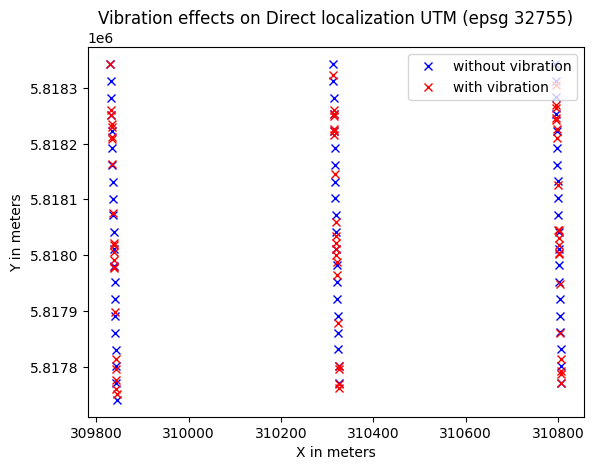

In [24]:
plt.plot(UTM_no_pert[:,0],UTM_no_pert[:,1],'bx')
plt.plot(UTM_pert[:,0],UTM_pert[:,1],'rx')
plt.legend(['without vibration','with vibration'])
plt.title('Vibration effects on Direct localization UTM (epsg 32755)')
plt.xlabel('X in meters')
plt.ylabel('Y in meters')
plt.show()